In [1]:
import torch, pickle, argparse, os, mlflow
import eagerpy as ep, matplotlib.pyplot as plt
from models import S2ConvNet
from data_loader import load_test_data
from foolbox import PyTorchModel
from foolbox.attacks import LinfFastGradientAttack
from attacks import NegEpsLinfFastGradientAttack
from tqdm.notebook import tqdm
from attack_helper import batched_predictions, run_batched_attack_cpu, batched_predictions_eps, batched_logits_eps
from mlflow.tracking.artifact_utils import get_artifact_uri
from foolbox.criteria import TargetedMisclassification

In [2]:
tracking_uri = 'sqlite:///mlruns/database.db'
mlflow.set_tracking_uri(tracking_uri)
df=mlflow.search_runs(experiment_names=['model_training'])
run_id=df[df['tags.mlflow.runName']==str(1668559990)]['run_id'].values[0]
artifact_path = get_artifact_uri(run_id=run_id, tracking_uri=tracking_uri)
dirs=os.listdir(artifact_path)

for s in dirs:
    if s.find('.ckpt') >= 0:
        checkpoint = s
        break

checkpoint_path = os.path.join(artifact_path, checkpoint)

best_model = torch.load(checkpoint_path)
hparams = argparse.Namespace(**best_model['hyper_parameters'])
model = S2ConvNet(hparams, None, None).eval()
model.load_state_dict(best_model['state_dict'])


TEST_PATH = "s2_mnist_cs1.gz"
test_data = load_test_data(TEST_PATH)

In [3]:
images_ = test_data[:][0]
labels_ = test_data[:][1]

images = images_[labels_ == 0][:10]
for i in range(1,10):
    images = torch.cat((images, images_[labels_ == i][:10]))
    
labels = labels_[labels_ == 0][:10]
for i in range(1,10):
    labels = torch.cat((labels, labels_[labels_ == i][:10]))

del images_, labels_

fmodel = PyTorchModel(model, bounds=(0, 255))
clean_pred = batched_predictions(model, images, 100)

  0%|          | 0/1 [00:00<?, ?it/s]

load 0.pkl.gz... done
load 0.pkl.gz... done
load 1.pkl.gz... done
load 21.pkl.gz... done
load 18.pkl.gz... done
load 15.pkl.gz... done
load 22.pkl.gz... done
load 17.pkl.gz... done
load 20.pkl.gz... done


In [4]:
epsilons = [0, 0.1, 0.25, 0.5, 1, 3, 5, 7.5, 10, 20, 50, 100]

attack = LinfFastGradientAttack(random_start=False)
neg_eps_attack = NegEpsLinfFastGradientAttack(random_start=False)

In [5]:
_, advs, success = run_batched_attack_cpu(attack, fmodel, images, clean_pred, epsilons, 100)
advs = torch.stack(advs)

_, advs_neg_eps, not_success_neg_eps = neg_eps_attack(fmodel, images.cuda(), TargetedMisclassification(clean_pred.cuda()), epsilons=epsilons)
advs_neg_eps = torch.stack(advs_neg_eps)

  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
success_neg_eps = ~not_success_neg_eps

In [7]:
cat_epsilons = torch.cat((torch.flip(-torch.as_tensor(epsilons), dims=(0,))[:-1], torch.as_tensor(epsilons)), dim=0)
cat_advs = torch.cat((torch.flip(advs_neg_eps.detach().cpu(), dims=(0,))[:-1], advs), dim=0)
cat_success = torch.cat((torch.flip(success_neg_eps.detach().cpu(), dims=(0,))[:-1], success), dim=0)
cat_adv_pred = batched_predictions_eps(model, cat_advs, 100)
cat_success_rate = ep.astensor(cat_success).float32().mean(axis=-1).raw
cat_logits = batched_logits_eps(model, cat_advs, 100)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

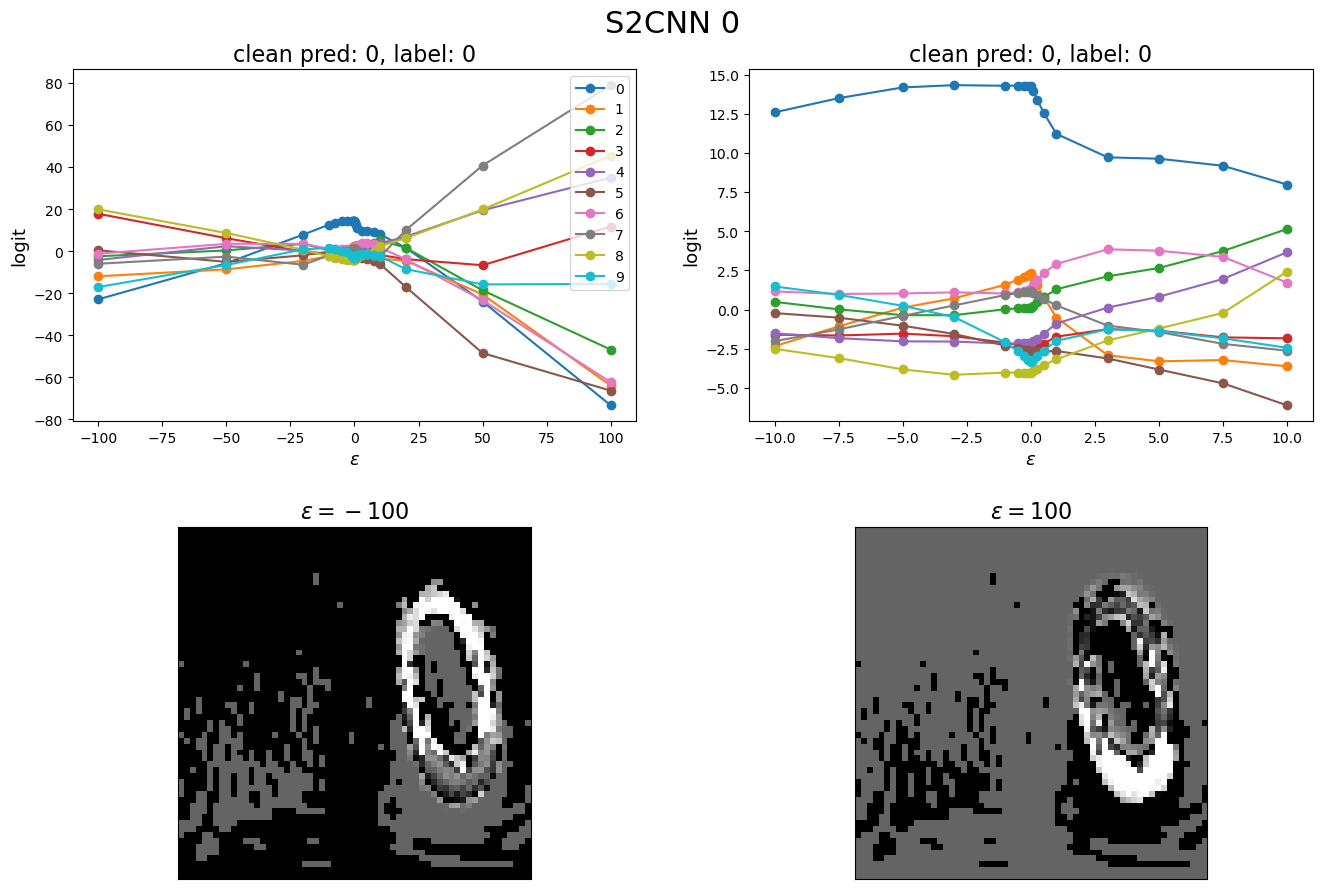

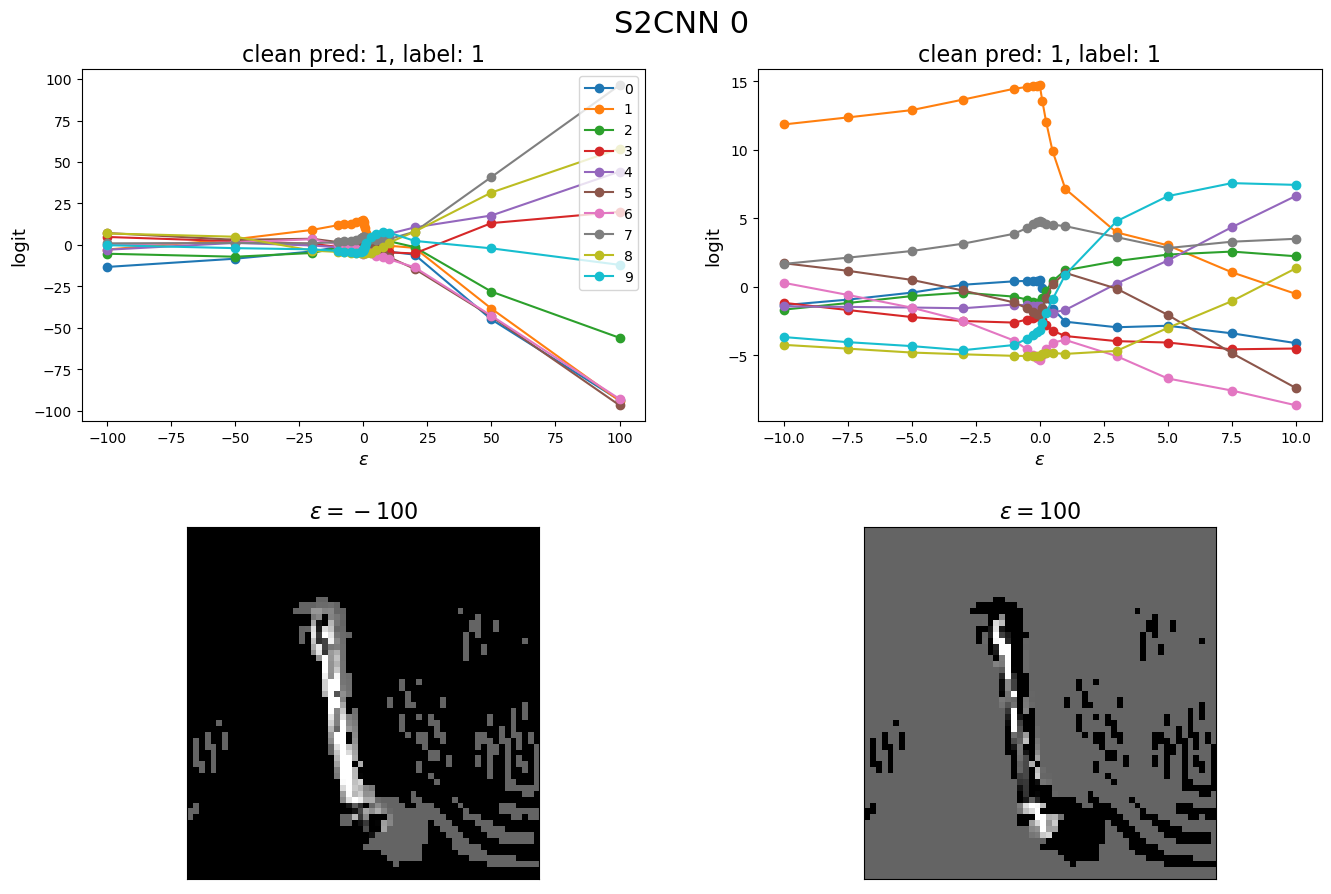

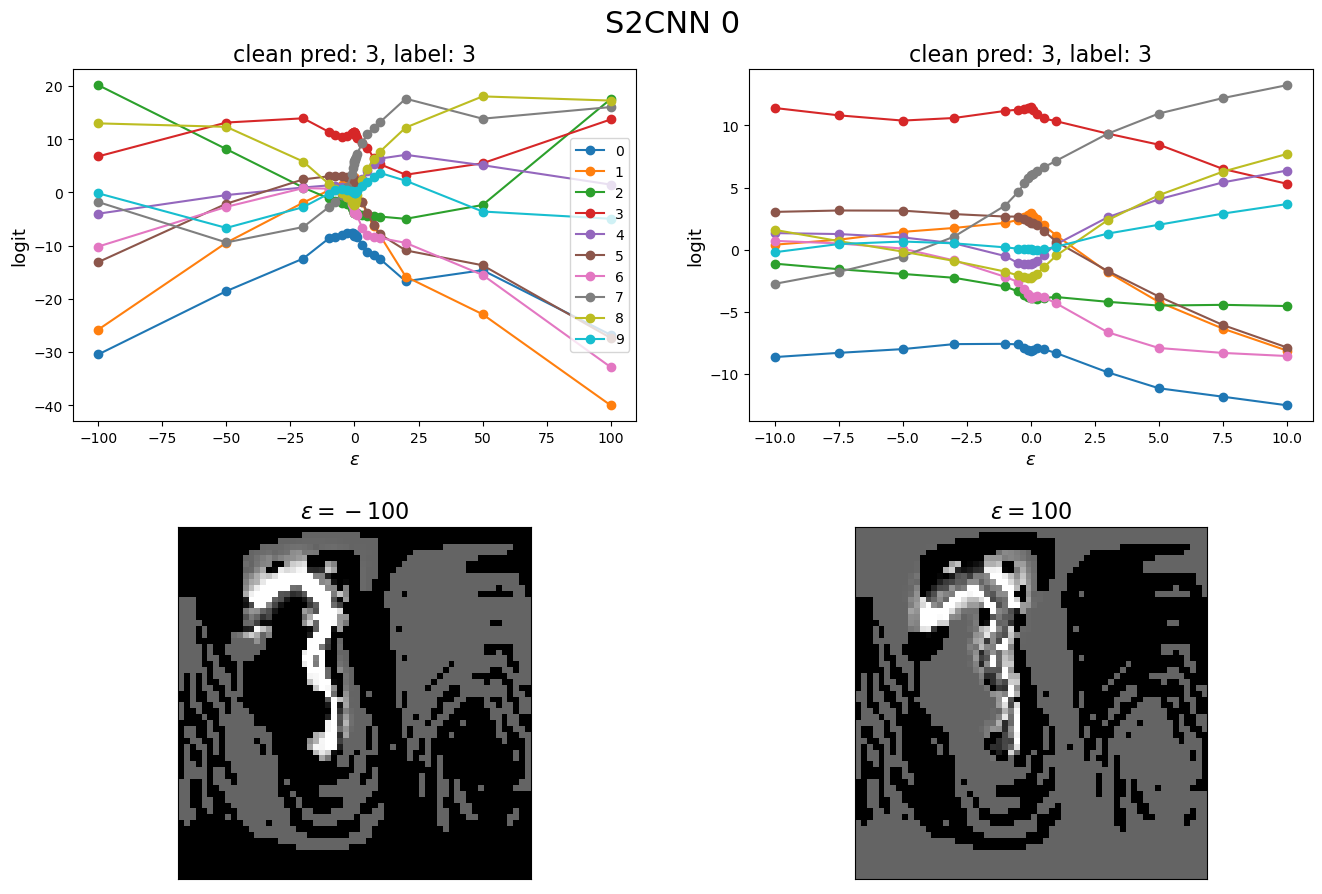

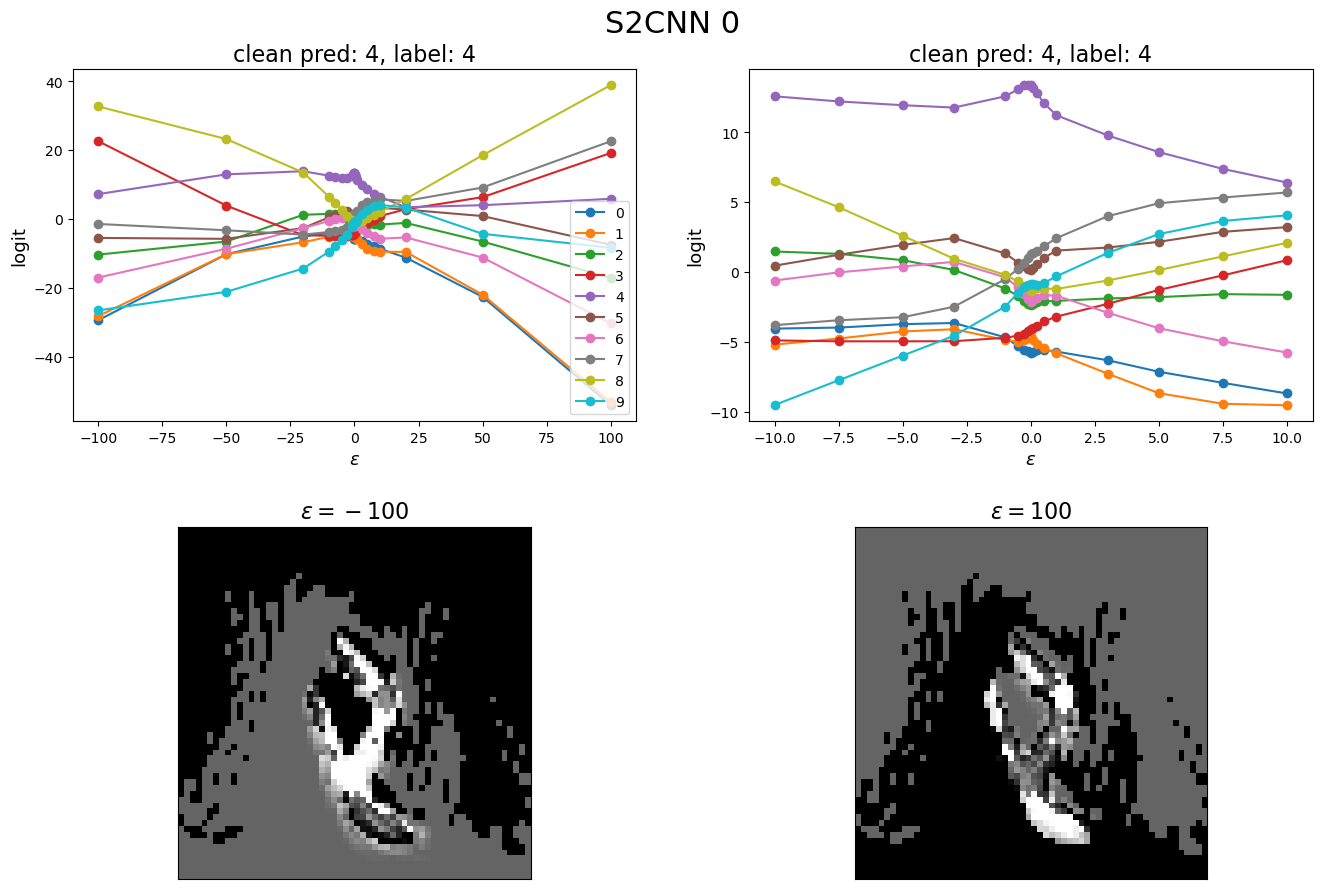

In [10]:
n_images = [2, 10, 33, 44]

for n_image in n_images:

    fontsize = 13
    title_fontsize = 16

    fig, axs = plt.subplots(nrows=2, ncols=2, figsize = (16, 10), gridspec_kw={'wspace':0.2, 'hspace':0.3})
    plt.suptitle('S2CNN 0', fontsize=22)
    plt.subplots_adjust(top=0.92)

    for i in range(10):
        axs[0,0].plot(cat_epsilons, cat_logits[:,n_image,i], 'o-', label=i)
        axs[0,1].plot(cat_epsilons[3:-3], cat_logits[3:-3,n_image,i], 'o-', label=i)
    axs[0,0].legend()
    axs[1,0].imshow(cat_advs[0, n_image, 0], cmap='gray')
    axs[1,1].imshow(cat_advs[-1, n_image, 0], cmap='gray')

    for j in range(2):
        axs[0,j].set_xlabel('$\epsilon$', fontsize=fontsize)
        axs[0,j].set_ylabel('logit', fontsize=fontsize)
        axs[0,j].set_title(f'clean pred: {clean_pred[n_image]}, label: {labels[n_image]}', fontsize=title_fontsize)
        axs[1,j].set_xticks([])
        axs[1,j].set_yticks([])

    axs[1,0].set_title('$\epsilon = -100$', fontsize=title_fontsize)
    axs[1,1].set_title('$\epsilon = 100$', fontsize=title_fontsize)
    
#     plt.savefig(f'S2CNN0_logits_{n_image}.pdf', bbox_inches="tight")

    plt.show()